In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/Leja0608/image-fusion.git


Cloning into 'image-fusion'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), 302.71 KiB | 1.75 MiB/s, done.


In [3]:
import os
os.listdir('image-fusion')


['rgb2.jpg',
 'rgb3.jpg',
 'thermal1.jpg',
 'rgb1.jpg',
 'Thermal3.jpg',
 'Thermal2.jpg',
 '.git']

##Step 1:
pairs thermal and RGB images by their numbering, converts them to RGB, and displays them side by side for visual analysis

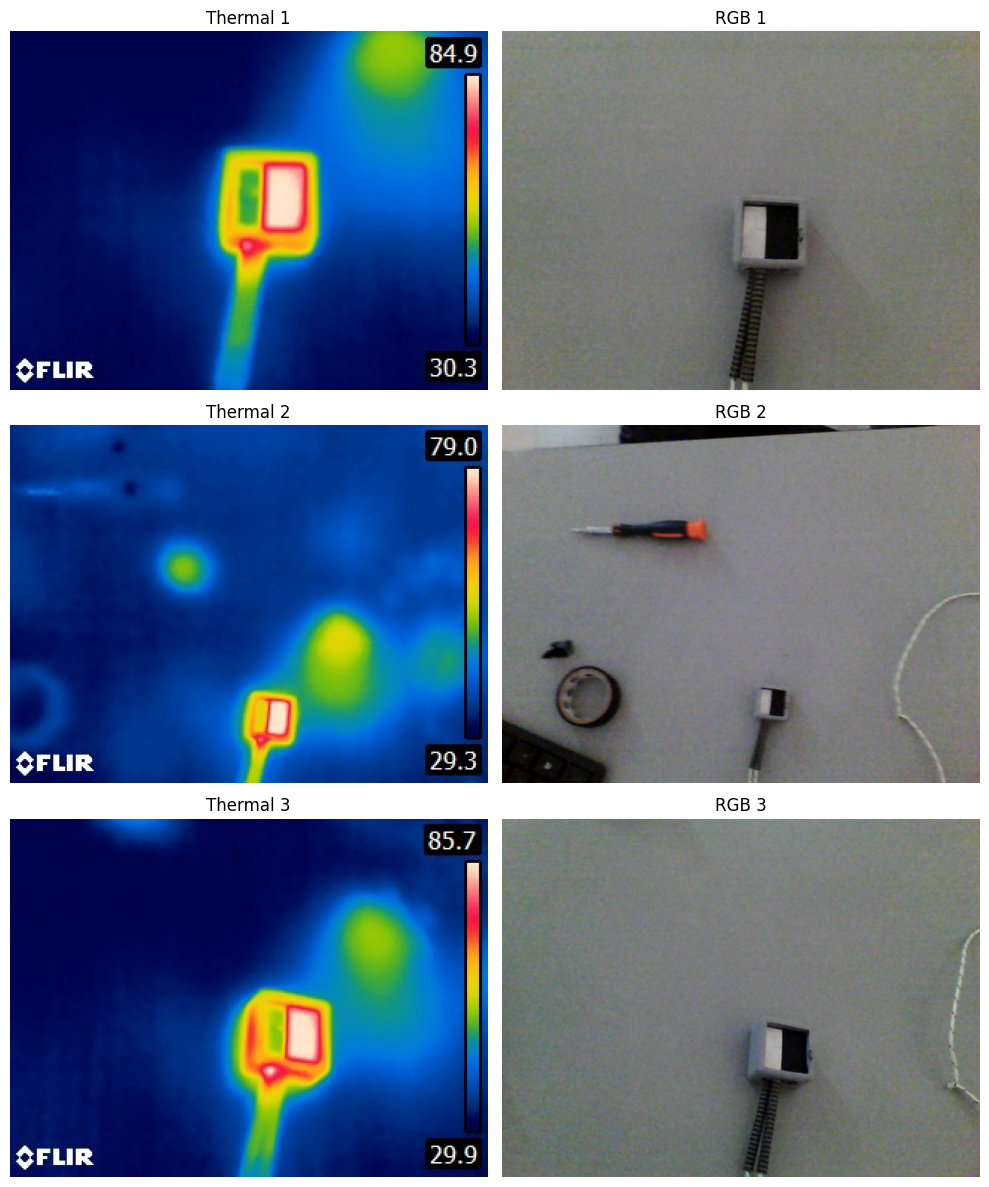

In [4]:
import cv2
import matplotlib.pyplot as plt
import os
import re

image_folder = 'image-fusion/'

image_files = sorted(os.listdir(image_folder), key=lambda x: x.lower())

thermal_images = sorted([img for img in image_files if 'thermal' in img.lower()], key=lambda x: int(re.findall(r'\d+', x)[0]))
rgb_images = sorted([img for img in image_files if 'rgb' in img.lower()], key=lambda x: int(re.findall(r'\d+', x)[0]))

thermal_paths = []
rgb_paths = []
thermal_imgs = []
rgb_imgs = []

plt.figure(figsize=(10, len(thermal_images) * 4))

for i in range(len(thermal_images)):
    thermal_path = os.path.join(image_folder, thermal_images[i])
    rgb_path = os.path.join(image_folder, rgb_images[i])

    thermal_img = cv2.imread(thermal_path)
    rgb_img = cv2.imread(rgb_path)

    thermal_img_rgb = cv2.cvtColor(thermal_img, cv2.COLOR_BGR2RGB)
    rgb_img_rgb = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)

    thermal_paths.append(thermal_path)
    rgb_paths.append(rgb_path)
    thermal_imgs.append(thermal_img_rgb)
    rgb_imgs.append(rgb_img_rgb)

    plt.subplot(len(thermal_images), 2, 2*i+1)
    plt.imshow(thermal_img_rgb)
    plt.axis('off')
    plt.title(f'Thermal {i+1}')

    plt.subplot(len(thermal_images), 2, 2*i+2)
    plt.imshow(rgb_img_rgb)
    plt.axis('off')
    plt.title(f'RGB {i+1}')

plt.tight_layout()
plt.show()


##Import libraries

In [5]:
!pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 13.2 MB/s eta 0:00:00


In [6]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import cv2

## Define the ImageProcessor class

In [7]:
class ImageProcessor:
    def __init__(self, thermal_path, rgb_path):
        self.thermal_path = thermal_path
        self.rgb_path = rgb_path
        self.thermal = None
        self.rgb = None

    def load_images(self):
        # Load images
        self.thermal = cv2.imread(self.thermal_path)
        self.rgb = cv2.imread(self.rgb_path)

        # Check if the images were loaded correctly
        if self.thermal is None:
            print("Error: Could not load the thermal image.")
        if self.rgb is None:
            print("Error: Could not load the RGB image.")

    def preprocess_images(self):
        # Ensure images are loaded
        if self.thermal is not None and self.rgb is not None:
            offset_image = np.zeros_like(self.rgb)
            offset_image[120:360, 160:480, :] = self.thermal
            self.thermal = offset_image

            # Convert images to grayscale and apply Gaussian filter
            self.thermal_gray = cv2.cvtColor(self.thermal, cv2.COLOR_BGR2GRAY)
            self.rgb_gray = cv2.cvtColor(self.rgb, cv2.COLOR_BGR2GRAY)

            self.thermal_gray = cv2.GaussianBlur(self.thermal_gray, (5, 5), 0)
            self.rgb_gray = cv2.GaussianBlur(self.rgb_gray, (5, 5), 0)

            # Image information
            print("Thermal shape:", self.thermal.shape)
            print("RGB shape:", self.rgb.shape)
            print("Thermal grayscale shape:", self.thermal_gray.shape)
            print("RGB grayscale shape:", self.rgb_gray.shape)

    def show_image(self, image, title, grayscale=False):
      if grayscale:
          plt.imshow(image, cmap='gray')
      else:
          plt.imshow(image)
      plt.title(title)
      plt.axis('off')
      plt.show()

## Define the MatrixOperations Class

In [8]:
class MatrixOperations:
    @staticmethod
    def apply_transformations(image):
        # Perform image transformations
        rows, cols = image.shape

        # Rotation - Reduced to 15 degrees
        M_rotation = cv2.getRotationMatrix2D((cols / 2, rows / 2), 15, 1)
        rotated_image = cv2.warpAffine(image, M_rotation, (cols, rows))

        # Translation - Reduced translation of 2 pixels
        M_translation = np.float32([[1, 0, 2], [0, 1, 2]])  # Translate 2 pixels
        translated_image = cv2.warpAffine(rotated_image, M_translation, (cols, rows))

        # Scaling - Reduced scaling factor to 1.2
        scaled_image = cv2.resize(translated_image, None, fx=1.2, fy=1.2, interpolation=cv2.INTER_LINEAR)

        # Deformation (Perspective) - Softer deformation with adjusted points
        pts1 = np.float32([[50, 50], [200, 50], [50, 200], [200, 200]])
        pts2 = np.float32([[30, 70], [180, 40], [70, 230], [220, 230]])
        M_perspective = cv2.getPerspectiveTransform(pts1, pts2)
        deformed_image = cv2.warpPerspective(scaled_image, M_perspective, (cols, rows))

        return deformed_image


##Define the ImageRegistration Class

In [96]:
class ImageRegistration:
    def __init__(self, fixed_image, moving_image):
        self.fixed_image = fixed_image
        self.moving_image = moving_image
        self.final_transform = None

    def register_images(self):
        # Initialize the registration method
        registration_method = sitk.ImageRegistrationMethod()

        # Configure the metric (Mattes Mutual Information)
        registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
        registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
        registration_method.SetMetricSamplingPercentage(0.8)

        # Multi-resolution framework (using Gaussian pyramids)
        registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
        registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
        registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        # Optimizer settings (using OnePlusOneEvolutionary)
        registration_method.SetOptimizerAsOnePlusOneEvolutionary(
            numberOfIterations=500,
            epsilon=1.63e-6,
            initialRadius=0.0028,
            growthFactor=1.1
        )

        # Initialize the affine transform
        initial_transform = sitk.AffineTransform(self.fixed_image.GetDimension())
        registration_method.SetInitialTransform(initial_transform, inPlace=False)

        # Set interpolator (linear by default, you can change it to something else like cubic)
        registration_method.SetInterpolator(sitk.sitkLinear)

        # Perform registration
        self.final_transform = registration_method.Execute(
            sitk.Cast(self.fixed_image, sitk.sitkFloat32),
            sitk.Cast(self.moving_image, sitk.sitkFloat32)
        )

        return self.final_transform

    def resample_image(self, moving_image):
        # Apply the transformation using resampling
        moving_image_resampled = sitk.Resample(
            moving_image,
            self.fixed_image,
            self.final_transform,
            sitk.sitkLinear,
            0.0,
            moving_image.GetPixelID()
        )
        return sitk.GetArrayFromImage(moving_image_resampled)


##Define the DerivativeAnalysis Class

In [10]:
class DerivativeAnalysis:
    @staticmethod
    def compute_gradient(image):
        # Compute the gradient of the image (numerical derivative)
        gradient_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
        gradient_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
        gradient_magnitude = cv2.magnitude(gradient_x, gradient_y)
        return gradient_magnitude

##Image Analysis

In [11]:
def analyze_images(rgb_img, thermal_img):
    print("\n--- Image Analysis ---")

    # Image types
    print(f"RGB Image Type: {type(rgb_img)}")
    print(f"Thermal Image Type: {type(thermal_img)}")

    # Image dimensions
    print(f"RGB Image Shape: {rgb_img.shape}")
    print(f"Thermal Image Shape: {thermal_img.shape}")

    # Check if both images are the same size
    if rgb_img.shape == thermal_img.shape:
        print("The images have the same dimensions.")
    else:
        print("The images have different dimensions.")

    # Image size in terms of pixels
    print(f"RGB Image Pixel Count: {rgb_img.size}")
    print(f"Thermal Image Pixel Count: {thermal_img.size}")

    # Image color channels
    print(f"RGB Image Channels: {rgb_img.shape[2]}")
    print(f"Thermal Image Channels: {thermal_img.shape[2]}")

    # Correlation between RGB and Thermal
    correlation = cv2.matchTemplate(rgb_img, thermal_img, cv2.TM_CCOEFF_NORMED)
    print(f"Correlation between RGB1 and Thermal1: {correlation.max()}")

In [16]:
analyze_images(rgb_imgs[2], thermal_imgs[2])


--- Image Analysis ---
RGB Image Type: <class 'numpy.ndarray'>
Thermal Image Type: <class 'numpy.ndarray'>
RGB Image Shape: (480, 640, 3)
Thermal Image Shape: (240, 320, 3)
The images have different dimensions.
RGB Image Pixel Count: 921600
Thermal Image Pixel Count: 230400
RGB Image Channels: 3
Thermal Image Channels: 3
Correlation between RGB1 and Thermal1: 0.16787074506282806


##Example of Usage

Thermal shape: (480, 640, 3)
RGB shape: (480, 640, 3)
Thermal grayscale shape: (480, 640)
RGB grayscale shape: (480, 640)


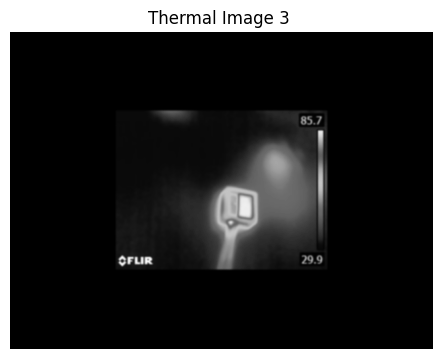

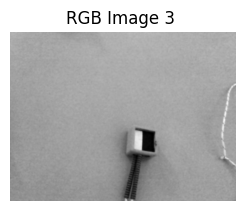

<Figure size 640x480 with 0 Axes>

In [70]:
thermal_img3 = thermal_imgs[2]
rgb_img3 = rgb_imgs[2]

image_processor = ImageProcessor(thermal_path, rgb_path)


image_processor.load_images()
image_processor.preprocess_images()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
image_processor.show_image(image_processor.thermal_gray, 'Thermal Image 3 ', grayscale=True)


plt.subplot(1, 2, 2)
image_processor.show_image(image_processor.rgb_gray, 'RGB Image 3 ', grayscale=True)

plt.tight_layout()
plt.show()

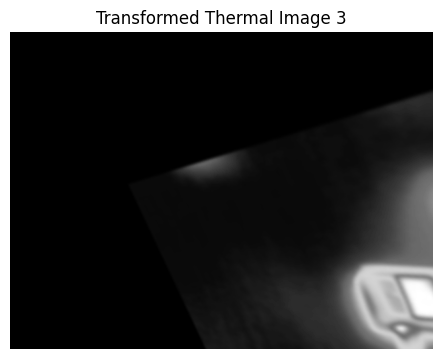

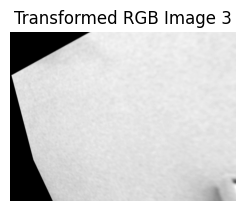

<Figure size 640x480 with 0 Axes>

In [57]:
transformed_thermal_img = MatrixOperations.apply_transformations(image_processor.thermal_gray)
transformed_rgb_img = MatrixOperations.apply_transformations(image_processor.rgb_gray)

plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
image_processor.show_image(transformed_thermal_img, 'Transformed Thermal Image 3', grayscale=True)

plt.subplot(1, 2, 2)
image_processor.show_image(transformed_rgb_img, 'Transformed RGB Image 3', grayscale=True)

plt.tight_layout()
plt.show()

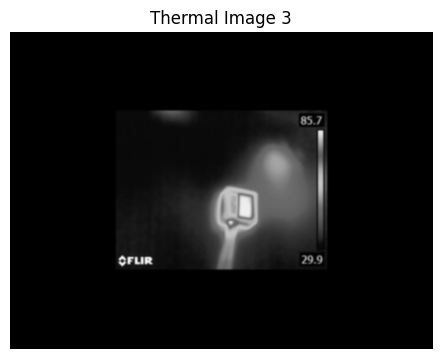

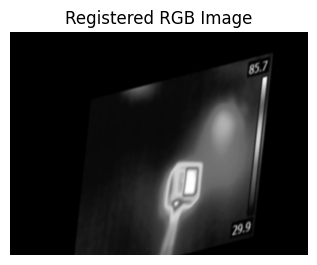

In [97]:
import SimpleITK as sitk
import matplotlib.pyplot as plt


def numpy_to_sitk(image_np):
    return sitk.GetImageFromArray(image_np)


moving_image  = numpy_to_sitk(image_processor.thermal_gray)
fixed_image= numpy_to_sitk(image_processor.rgb_gray)


registration = ImageRegistration(fixed_image, moving_image)


final_transform = registration.register_images()

resampled_rgb_image = registration.resample_image(moving_image)


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
image_processor.show_image(image_processor.thermal_gray, 'Thermal Image 3', grayscale=True)


plt.subplot(1, 2, 2)
plt.imshow(resampled_rgb_image, cmap='gray')
plt.title('Registered RGB Image')
plt.axis('off')

plt.tight_layout()
plt.show()


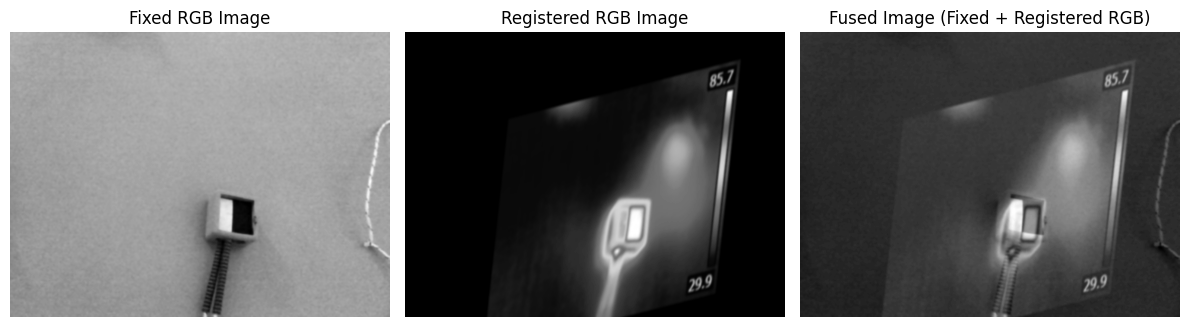

In [98]:

fixed_image_np = sitk.GetArrayFromImage(fixed_image)
resampled_rgb_image_resized = cv2.resize(resampled_rgb_image, (fixed_image_np.shape[1], fixed_image_np.shape[0]))

fused_image = cv2.addWeighted(fixed_image_np, 0.5, resampled_rgb_image_resized, 0.5, 0)


plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(fixed_image_np, cmap='gray')
plt.title('Fixed RGB Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(resampled_rgb_image_resized, cmap='gray')
plt.title('Registered RGB Image')
plt.axis('off')


plt.subplot(1, 3, 3)
plt.imshow(fused_image, cmap='gray')
plt.title('Fused Image (Fixed + Registered RGB)')
plt.axis('off')

plt.tight_layout()
plt.show()


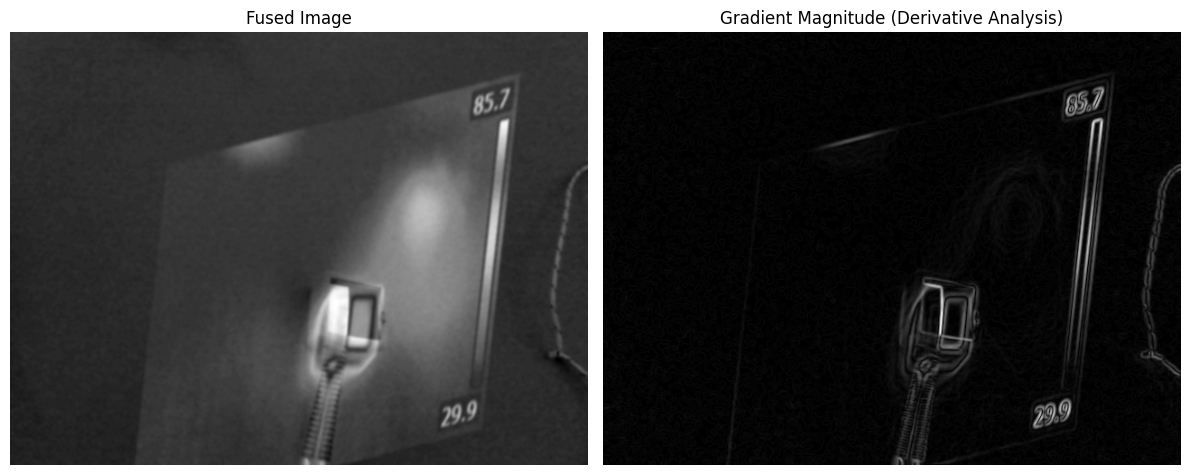

In [99]:
gradient_magnitude = DerivativeAnalysis.compute_gradient(fused_image)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(fused_image, cmap='gray')
plt.title('Fused Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(gradient_magnitude, cmap='gray')
plt.title('Gradient Magnitude (Derivative Analysis)')
plt.axis('off')

plt.tight_layout()
plt.show()